# Extract Image using Semantic Segmentation

---

This notebook's CI test result for us-west-2 is as follows. CI test results in other regions can be found at the end of the notebook. 

![This us-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-2/introduction_to_amazon_algorithms|jumpstart_semantic_segmentation|Amazon_JumpStart_Semantic_Segmentation_Extract_Image.ipynb)

---

---
Welcome to Amazon [SageMaker JumpStart](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-jumpstart.html)! You can use JumpStart to solve many Machine Learning tasks through one-click in SageMaker Studio, or through [SageMaker JumpStart API](https://sagemaker.readthedocs.io/en/stable/doc_utils/jumpstart.html). In this demo notebook, we demonstrate how to use the JumpStart API for Semantic Segmentation. Semantic segmentation is the task of detecting and delineating each distinct object of interest appearing in an image. It is a fine-grained, pixel-level approach to developing computer vision applications. It tags every pixel in an image with a class label from a predefined set of classes. It differs from Instance Segmentation in the following: Semantic Segmentation treats multiple objects of the same class as a single entity whereas Instance Segmentation treats multiple objects of the same class as distinct individual instances.


In this notebook, we demonstrate two use cases of semantic segmentation models: 

* How to use pre-trained Semantic Segmentation models for inference.
* How to use JumpStart transfer learning algorithm to finetune a Semantic Segmentation model on a custom dataset.

---

1. [Set Up](#1.-Set-Up)
2. [Select a pre-trained model](#2.-Select-a-pre-trained-model)
3. [Run inference on the pre-trained model](#3.-Run-inference-on-the-pre-trained-model)
    * [Retrieve JumpStart Artifacts & Deploy an Endpoint](#3.1.-Retrieve-JumpStart-Artifacts-&-Deploy-an-Endpoint)
    * [Download an example image for inference](#3.2.-Download-an-example-image-for-inference)
    * [Query endpoint and parse response](#3.3.-Query-endpoint-and-parse-response)
    * [Display model predictions](#3.4.-Display-model-predictions)
4. [Display and Extract Model Predicted Image](#4.-Display-and-Extract-Model-Predicted-Image)
    * [Extract Model Predicted Image](#4.1.-Extract-Model-Predicted-Image)
    * [Display Extracted Model Predicted Image](#4.2.-Display-Extracted-Model-Predicted-Image)
    * [Clean up the endpoint](#4.3.-Clean-up-the-endpoint)
    

Note: This notebook was tested on ml.t3.medium instance in Amazon SageMaker Studio with Python 3 (Data Science) kernel and in Amazon SageMaker Notebook instance with conda_python3 kernel.

## 1. Set Up

---
Before executing the notebook, there are some initial steps required for set up. This notebook requires latest version of sagemaker and ipywidgets

---

In [1]:
!pip install sagemaker ipywidgets --upgrade --quiet

### Permissions and environment variables

---
To train and host on Amazon SageMaker, we need to set up and authenticate the use of AWS services. Here, we use the execution role associated with the current notebook as the AWS account role with SageMaker access. It has necessary permissions, including access to your data in S3. 

---

In [17]:
import sagemaker, boto3, json
from sagemaker import get_execution_role

aws_role = get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


### 2. Select a pre-trained model

***
Here, we download jumpstart model_manifest file from the jumpstart s3 bucket, filter out all the Semantic Segmentation models and select a model for inference.
***

In [3]:
from ipywidgets import Dropdown

# download JumpStart model_manifest file.
boto3.client("s3").download_file(
    f"jumpstart-cache-prod-{aws_region}", "models_manifest.json", "models_manifest.json"
)
with open("models_manifest.json", "rb") as json_file:
    model_list = json.load(json_file)

# filter-out all the Semantic Segmentation models from the manifest list.
semseg_models = []
for model in model_list:
    model_id = model["model_id"]
    if "-semseg-" in model_id and model_id not in semseg_models:
        semseg_models.append(model_id)

print(f"\033[38;5;2mChose a model: \033[0;0m\n")

# display the model-ids in a dropdown to select a model for inference.
model_dropdown = Dropdown(
    options=semseg_models,
    value="mxnet-semseg-fcn-resnet101-coco",
    description="",
    style={"description_width": "initial"},
    layout={"width": "max-content"},
)
display(model_dropdown)

Chose a model: 



Dropdown(index=1, layout=Layout(width='max-content'), options=('mxnet-semseg-fcn-resnet101-ade', 'mxnet-semseg…

In [4]:
# model_version="*" fetches the latest version of the model
model_id, model_version = model_dropdown.value, "*"

In [5]:
model_id, model_version

('mxnet-semseg-fcn-resnet101-coco', '*')

## 3. Run inference on the pre-trained model

***

Using JumpStart, we can perform inference on the pre-trained model, even without fine-tuning it first on a new dataset. 
***

### 3.1. Retrieve JumpStart Artifacts & Deploy an Endpoint

***
We retrieve the `deploy_image_uri`, `deploy_source_uri`, and `base_model_uri` for the pre-trained model. To host the pre-trained base-model, we create an instance of [`sagemaker.model.Model`](https://sagemaker.readthedocs.io/en/stable/api/inference/model.html) and deploy it.
***

In [26]:
import sagemaker
import boto3
# from time import gmtime, strftime
from datetime import datetime

boto_session = boto3.session.Session()
sm_session = sagemaker.session.Session()
region = boto_session.region_name

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [11]:
sm_role = sagemaker.get_execution_role()
# Feel free to use your own role here
# sm_role = "arn:aws:iam::123456789012:role/sagemaker-custom-role"
print(f"Using Role: {sm_role}")
s3_bucket = sm_session.default_bucket()
print(f"Will use bucket '{s3_bucket}' for storing all resources related to this notebook")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Using Role: arn:aws:iam::287758680514:role/service-role/AmazonSageMaker-ExecutionRole-20231027T004238
Will use bucket 'sagemaker-us-east-1-287758680514' for storing all resources related to this notebook


In [6]:
# from sagemaker import image_uris
#, model_uris, script_uris, hyperparameters
# from sagemaker.model import Model
# from sagemaker.predictor import Predictor
# from sagemaker.utils import name_from_base


endpoint_name = name_from_base(f"jumpstart-example-infer-{model_id}")

In [20]:
bucket_prefix = "DEMO-async-inference"
resource_name = "AsyncInferenceDemo-{}-{}"

In [7]:
endpoint_name

'jumpstart-example-infer-mxnet-semseg-fc-2023-10-28-03-29-08-394'

In [15]:
from sagemaker import image_uris

In [17]:
inference_instance_type = "ml.m5.xlarge"

In [19]:
# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    image_scope="inference",
    model_id=model_id,
    model_version=model_version,
    instance_type=inference_instance_type,
)
deploy_image_uri

'763104351884.dkr.ecr.us-east-1.amazonaws.com/mxnet-inference:1.9.0-cpu-py38'

In [27]:
model_name = resource_name.format("Model", datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))

In [28]:
model_name

'AsyncInferenceDemo-Model-2023-10-28-03-46-48'

In [31]:
# Retrieve the base model uri
base_model_uri = model_uris.retrieve(
    model_id=model_id, model_version=model_version, model_scope="inference"
)
base_model_uri

's3://jumpstart-cache-prod-us-east-1/mxnet-infer/v1.1.0/infer-mxnet-semseg-fcn-resnet101-coco.tar.gz'

In [33]:
# Retrieve the inference script uri. This includes scripts for model loading, inference handling etc.
deploy_source_uri = script_uris.retrieve(
    model_id=model_id, model_version=model_version, script_scope="inference"
)
deploy_source_uri

's3://jumpstart-cache-prod-us-east-1/source-directory-tarballs/mxnet/inference/semseg/v1.2.1/sourcedir.tar.gz'

In [18]:
from sagemaker.model import Model
from sagemaker.predictor import Predictor

# this is probably wrong
# model_predictor = Model(
#     name=model_name,
#     image_uri=deploy_image_uri,
#     model_data=base_model_uri,
#     role=sm_role,
#     predictor_cls=Predictor,
# )


# Create the SageMaker model instance
# model_predictor = Model(
#     image_uri=deploy_image_uri,
#     source_dir=deploy_source_uri,
#     model_data=base_model_uri,
#     entry_point="inference.py",  # entry point file in source_dir and present in deploy_source_uri
#     role=aws_role,
#     predictor_cls=Predictor,
#     name=endpoint_name,
# )

model_predictor = Model(
    image_uri='763104351884.dkr.ecr.us-east-1.amazonaws.com/mxnet-inference:1.9.0-cpu-py38',
    source_dir='s3://jumpstart-cache-prod-us-east-1/source-directory-tarballs/mxnet/inference/semseg/v1.2.1/sourcedir.tar.gz',
    model_data='s3://jumpstart-cache-prod-us-east-1/mxnet-infer/v1.1.0/infer-mxnet-semseg-fcn-resnet101-coco.tar.gz',
    entry_point="inference.py",  # entry point file in source_dir and present in deploy_source_uri
    role=aws_role,
    predictor_cls=Predictor,
    name='jumpstart-example-infer-mxnet-semseg-fc-2023-10-28-03-29-08-394'
)



sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [38]:
from sagemaker.async_inference.async_inference_config import AsyncInferenceConfig

async_config = AsyncInferenceConfig(
    output_path=f"s3://{s3_bucket}/{bucket_prefix}/output",
    max_concurrent_invocations_per_instance=4,
    # Optionally specify Amazon SNS topics
    # notification_config = {
    # "SuccessTopic": "arn:aws:sns:<aws-region>:<account-id>:<topic-name>",
    # "ErrorTopic": "arn:aws:sns:<aws-region>:<account-id>:<topic-name>",
    # }
)

In [39]:

async_predictor = model_predictor.deploy(
    async_inference_config=async_config,
    instance_type="ml.m5.xlarge",
    initial_instance_count=1,
    endpoint_name=endpoint_name,
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
----!

In [15]:
sagemaker_client = boto3.client('sagemaker')
# from sagemaker import list-models
response = sagemaker_client.list_models()
response

{'Models': [{'ModelName': 'jumpstart-example-infer-mxnet-semseg-fc-2023-10-28-03-29-08-394',
   'ModelArn': 'arn:aws:sagemaker:us-east-1:287758680514:model/jumpstart-example-infer-mxnet-semseg-fc-2023-10-28-03-29-08-394',
   'CreationTime': datetime.datetime(2023, 10, 28, 4, 5, 53, 811000, tzinfo=tzlocal())},
  {'ModelName': 'AsyncInferenceDemo-Model-2023-10-27-06-32-21',
   'ModelArn': 'arn:aws:sagemaker:us-east-1:287758680514:model/asyncinferencedemo-model-2023-10-27-06-32-21',
   'CreationTime': datetime.datetime(2023, 10, 27, 6, 33, 56, 671000, tzinfo=tzlocal())}],
 'ResponseMetadata': {'RequestId': 'b6ef3ab3-0338-47eb-89b0-7aadd93ddf45',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'b6ef3ab3-0338-47eb-89b0-7aadd93ddf45',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '446',
   'date': 'Sat, 28 Oct 2023 19:08:45 GMT'},
  'RetryAttempts': 0}}

In [35]:
endpoint_name

'jumpstart-example-infer-mxnet-semseg-fc-2023-10-28-03-29-08-394'

In [3]:
jumpstart_assets_s3_bucket = f"jumpstart-cache-prod-{aws_region}"
pedestrian_img_key_prefix = "inference-notebook-assets"
pedestrian_img = "img_pedestrian.png"

boto3.client("s3").download_file(
    jumpstart_assets_s3_bucket, f"{pedestrian_img_key_prefix}/{pedestrian_img}", pedestrian_img
)

In [5]:
import json


def query(model_predictor, image_file_name):
    """Query the model predictor."""

    with open(image_file_name, "rb") as file:
        input_img_rb = file.read()

    query_response = model_predictor.predict(
        input_img_rb,
        {
            "ContentType": "application/x-image",
            "Accept": "application/json;verbose",
        },
    )
    return query_response


def parse_response(query_response):
    """Parse response and return predictions as well as the set of all labels and object labels present in the image."""
    response_dict = json.loads(query_response)
    return response_dict["predictions"], response_dict["labels"], response_dict["image_labels"]

In [6]:
query_response = query(async_predictor, pedestrian_img)

predictions, labels, image_labels = parse_response(query_response)
print("Objects present in the picture:", image_labels)

NameError: name 'async_predictor' is not defined

In [7]:
async_predictor

NameError: name 'async_predictor' is not defined

In [6]:


inference_instance_type = "ml.m5.xlarge"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    image_scope="inference",
    model_id=model_id,
    model_version=model_version,
    instance_type=inference_instance_type,
)

# Retrieve the inference script uri. This includes scripts for model loading, inference handling etc.
deploy_source_uri = script_uris.retrieve(
    model_id=model_id, model_version=model_version, script_scope="inference"
)


# Retrieve the base model uri
base_model_uri = model_uris.retrieve(
    model_id=model_id, model_version=model_version, model_scope="inference"
)


# Create the SageMaker model instance
model = Model(
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    model_data=base_model_uri,
    entry_point="inference.py",  # entry point file in source_dir and present in deploy_source_uri
    role=aws_role,
    predictor_cls=Predictor,
    name=endpoint_name,
)

# deploy the Model. Note that we need to pass Predictor class when we deploy model through Model class,
# for being able to run inference through the sagemaker API.
base_model_predictor = model.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    predictor_cls=Predictor,
    endpoint_name=endpoint_name,
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
-----!

### 3.2. Download an example image for inference
---
We download an example image from the JumpStart assets S3 bucket.

---

In [7]:
jumpstart_assets_s3_bucket = f"jumpstart-cache-prod-{aws_region}"
pedestrian_img_key_prefix = "inference-notebook-assets"
pedestrian_img = "img_pedestrian.png"

boto3.client("s3").download_file(
    jumpstart_assets_s3_bucket, f"{pedestrian_img_key_prefix}/{pedestrian_img}", pedestrian_img
)

### 3.3. Query endpoint and parse response

---
Input to the endpoint is a single image in binary format. Response of the endpoint is a predicted label for each pixel in the image. 

---

In [8]:
import json


def query(model_predictor, image_file_name):
    """Query the model predictor."""

    with open(image_file_name, "rb") as file:
        input_img_rb = file.read()

    query_response = model_predictor.predict(
        input_img_rb,
        {
            "ContentType": "application/x-image",
            "Accept": "application/json;verbose",
        },
    )
    return query_response


def parse_response(query_response):
    """Parse response and return predictions as well as the set of all labels and object labels present in the image."""
    response_dict = json.loads(query_response)
    return response_dict["predictions"], response_dict["labels"], response_dict["image_labels"]

In [9]:
query_response = query(base_model_predictor, pedestrian_img)

predictions, labels, image_labels = parse_response(query_response)
print("Objects present in the picture:", image_labels)

Objects present in the picture: ['wall', 'building, edifice', 'tree', 'road, route', 'signboard, sign', 'person, individual, someone, somebody, mortal, soul', 'sidewalk, pavement', 'earth, ground', 'plant, flora, plant life']


In [12]:
base_model_predictor.endpoint

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


'jumpstart-example-infer-mxnet-semseg-fc-2023-10-27-06-03-05-942'

In [11]:
dir(base_model_predictor)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_accept',
 '_content_type',
 '_context',
 '_create_request_args',
 '_delete_endpoint_config',
 '_endpoint_config_name',
 '_get_endpoint_config_name',
 '_get_model_monitor_class',
 '_get_model_names',
 '_handle_response',
 '_model_names',
 'accept',
 'content_type',
 'delete_endpoint',
 'delete_model',
 'delete_predictor',
 'deserializer',
 'disable_data_capture',
 'enable_data_capture',
 'endpoint',
 'endpoint_context',
 'endpoint_name',
 'list_monitors',
 'predict',
 'sagemaker_session',
 'serializer',
 'update_data_capture_config',
 'update_endpoin

### 3.4. Display model predictions
---
Next, we display the bounding boxes overlaid on the original image. To get color palette for visualization, we borrow the VOC palette implementation from [GluonCV](https://cv.gluon.ai/_modules/gluoncv/utils/viz/segmentation.html#get_color_pallete)  

---

In [13]:
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image


def getvocpalette(num_cls):
    """Get a color palette."""

    n = num_cls
    palette = [0] * (n * 3)
    for j in range(0, n):
        lab = j
        palette[j * 3 + 0] = 0
        palette[j * 3 + 1] = 0
        palette[j * 3 + 2] = 0
        i = 0
        while lab > 0:
            palette[j * 3 + 0] |= ((lab >> 0) & 1) << (7 - i)
            palette[j * 3 + 1] |= ((lab >> 1) & 1) << (7 - i)
            palette[j * 3 + 2] |= ((lab >> 2) & 1) << (7 - i)
            i = i + 1
            lab >>= 3
    return palette


def display_predictions(predictions):
    """Display predictions with each pixel subsituted by the color of the corresponding label."""

    palette = getvocpalette(256)
    npimg = np.array(predictions)
    npimg[npimg == -1] = 255
    mask = Image.fromarray(npimg.astype("uint8"))

    mask.putpalette(palette)
    mask.save("Mask_putput.png")
    mmask = mpimg.imread("Mask_putput.png")
    plt.imshow(mask)

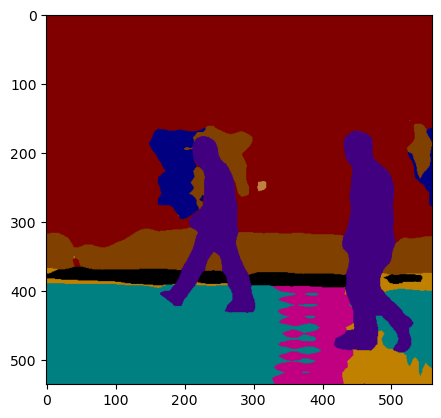

In [14]:
display_predictions(predictions)

### 4. Display and Extract Model Predicted Image

---
We now have the model predicted mask, so let's use it to extract the pedestrian image out of the original image.

---

### 4.1. Extract Model Predicted Image


---
Using the pixel data of model predicted mask, we overlay it on top of the image pixels to remove the background details and retrieve pedestrian image. After executing below cell, you can find the Final_pedestrian.jpg in your folder, which is the extracted image of the pedestrians. 

---


In [15]:
# Convert the pedestrian Image to JPEG so we get the pixel details
im1 = Image.open(r"img_pedestrian.png")
rgb_im1 = im1.convert("RGB")
rgb_im1.save("img_pedestrian-1.jpg")

# Convert the mask output to JPEG so we get the pixel details
im2 = Image.open(r"Mask_putput.png")
rgb_im2 = im2.convert("RGB")
rgb_im2.save("Mask_putput-1.jpg")

im1 = Image.open("img_pedestrian-1.jpg")
pixelMap1 = im1.load()
im2 = Image.open("Mask_putput-1.jpg")
pixelMap2 = im2.load()
width1, height1 = im1.size
width2, height2 = im2.size


# Set the height and width to the largest image

if width2 > width1:
    width = width2
else:
    width = width1

if height2 > height1:
    height = height2
else:
    height = height1


for i in range(width):  # for every col:
    for j in range(height):  # For every row
        R1, G1, B1 = pixelMap2[i, j]
        if R1 != 0 and G1 != 0 and B1 != 0:
            pixelMap2[i, j] = pixelMap1[i, j]
        else:
            pixelMap2[i, j] = (0, 0, 0)


im2 = im2.save("Final_Pedestrians.jpg")


---
Let's display the original pedestrian image with the background included
___

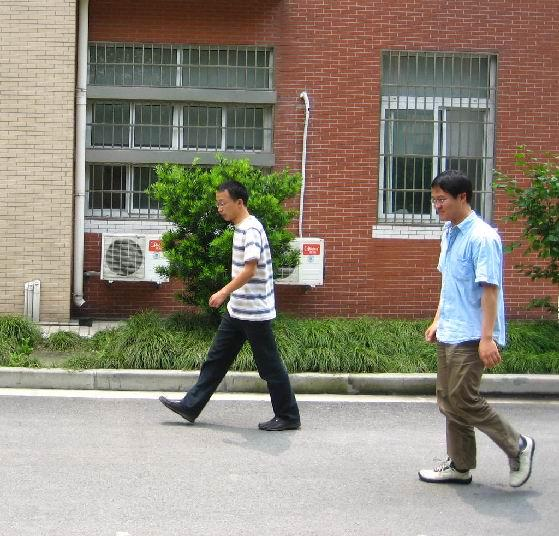

In [16]:
im1.show()

### 4.2. Display Extracted Model Predicted Image
---
Display the pedestrian image after extraction 
___

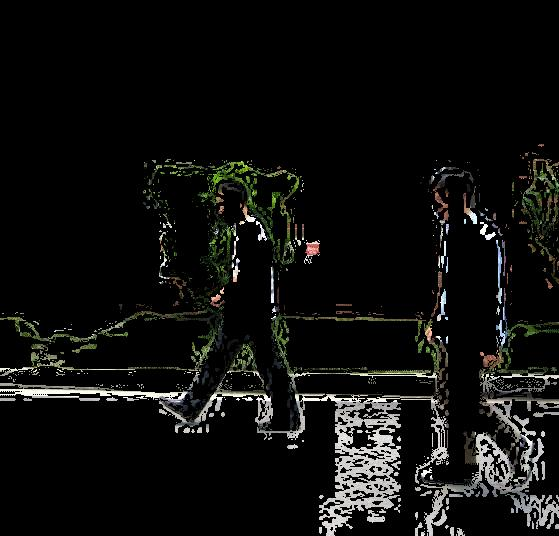

In [17]:
im3 = Image.open("Final_Pedestrians.jpg")
im3.show()

### 4.3. Clean up the endpoint

In [18]:
# Delete the SageMaker endpoint
base_model_predictor.delete_model()
base_model_predictor.delete_endpoint()

## Notebook CI Test Results

This notebook was tested in multiple regions. The test results are as follows, except for us-west-2 which is shown at the top of the notebook.

![This us-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-1/introduction_to_amazon_algorithms|jumpstart_semantic_segmentation|Amazon_JumpStart_Semantic_Segmentation_Extract_Image.ipynb)

![This us-east-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-2/introduction_to_amazon_algorithms|jumpstart_semantic_segmentation|Amazon_JumpStart_Semantic_Segmentation_Extract_Image.ipynb)

![This us-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-1/introduction_to_amazon_algorithms|jumpstart_semantic_segmentation|Amazon_JumpStart_Semantic_Segmentation_Extract_Image.ipynb)

![This ca-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ca-central-1/introduction_to_amazon_algorithms|jumpstart_semantic_segmentation|Amazon_JumpStart_Semantic_Segmentation_Extract_Image.ipynb)

![This sa-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/sa-east-1/introduction_to_amazon_algorithms|jumpstart_semantic_segmentation|Amazon_JumpStart_Semantic_Segmentation_Extract_Image.ipynb)

![This eu-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-1/introduction_to_amazon_algorithms|jumpstart_semantic_segmentation|Amazon_JumpStart_Semantic_Segmentation_Extract_Image.ipynb)

![This eu-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-2/introduction_to_amazon_algorithms|jumpstart_semantic_segmentation|Amazon_JumpStart_Semantic_Segmentation_Extract_Image.ipynb)

![This eu-west-3 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-3/introduction_to_amazon_algorithms|jumpstart_semantic_segmentation|Amazon_JumpStart_Semantic_Segmentation_Extract_Image.ipynb)

![This eu-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-central-1/introduction_to_amazon_algorithms|jumpstart_semantic_segmentation|Amazon_JumpStart_Semantic_Segmentation_Extract_Image.ipynb)

![This eu-north-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-north-1/introduction_to_amazon_algorithms|jumpstart_semantic_segmentation|Amazon_JumpStart_Semantic_Segmentation_Extract_Image.ipynb)

![This ap-southeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-1/introduction_to_amazon_algorithms|jumpstart_semantic_segmentation|Amazon_JumpStart_Semantic_Segmentation_Extract_Image.ipynb)

![This ap-southeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-2/introduction_to_amazon_algorithms|jumpstart_semantic_segmentation|Amazon_JumpStart_Semantic_Segmentation_Extract_Image.ipynb)

![This ap-northeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-1/introduction_to_amazon_algorithms|jumpstart_semantic_segmentation|Amazon_JumpStart_Semantic_Segmentation_Extract_Image.ipynb)

![This ap-northeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-2/introduction_to_amazon_algorithms|jumpstart_semantic_segmentation|Amazon_JumpStart_Semantic_Segmentation_Extract_Image.ipynb)

![This ap-south-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-south-1/introduction_to_amazon_algorithms|jumpstart_semantic_segmentation|Amazon_JumpStart_Semantic_Segmentation_Extract_Image.ipynb)
